In [420]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from visualize import PyramidVisualizer, get_dataset, display_image, simple_visualizer, visualize_residuals
import metroem
from metroem.aligner import Aligner
from corgie import residuals
import cloudvolume as cv
import matplotlib.pylab as plt
import torch
import tqdm
import numpy as np
from matplotlib.ticker import FormatStrFormatter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [445]:
img_mip = 9

layer_paths = {
    #'img_v14': 'matrix://seamless-paper/prod_x3/processed/img/img_v14_normed',
    #'img_aligned': 'matrix://seamless-paper/prod_x3/processed/img/img_run_x11_normed',
    'emb_v14_cpc64': 'precomputed://matrix://seamless-paper/prod_x3/cpc64_emb_v14_run_x11_a_x20',
    'emb_cpc64': 'precomputed://matrix://seamless-paper/prod_x3/cpc64_emb_run_x11_a_x20',
    'img_v14_cpc64': 'precomputed://matrix://seamless-paper/prod_x3/cpc64_img_v14_run_x11_a_x20',
    'img_cpc64': 'precomputed://matrix://seamless-paper/prod_x3/cpc64_img_run_x11_a_x20'
}

cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in layer_paths.items()
}

In [487]:

def get_imgs(z, x_size=260, y_size=260, x_start=70000, y_start=0):
    x_size = x_size * 2**img_mip
    y_size = y_size * 2**img_mip
    imgs = {
        name: cvs[name][(x_start)//2**img_mip:(x_start+x_size)//2**img_mip, (y_start)//2**img_mip:(y_start+y_size)//2**img_mip, z:z+1].squeeze() for name in layer_paths
    }
    for k, img in imgs.items():
        if (img != img).sum() > 0: #CPC
            img[img != img] = 0
            
            '''img[img != 0] -= img.min()
            img[img != 0] *= -1
            img[img != 0] += 2
            img[img == 0] += 0.5'''
            
            img[img != 0] -= img.min()
            img[img != 0] *= -1
            img[img != 0] += 2
            img[img == 0] += 0.5
        
        
    return imgs

In [488]:
imgs = {}
imgs[1003] = get_imgs(z=1003)
imgs[1004] = get_imgs(z=1004)

In [489]:
simple_visualizer().visualize([imgs[1004]['emb_v14_cpc64'], imgs[1004]['emb_cpc64'], imgs[1004]['img_v14_cpc64'], imgs[1004]['img_cpc64']])

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3), value=0), IntText(value=1, des…

In [460]:
src_v14 = torch.tensor(imgs[1003]['img_v14'])
tgt_v14 = torch.tensor(imgs[1004]['img_v14'])

src_aligned = torch.tensor(imgs[1003]['img_aligned'])
tgt_aligned = torch.tensor(imgs[1004]['img_aligned'])

diff_v14 = (src_v14 - tgt_v14).abs()
diff_aligned = (src_aligned - tgt_aligned).abs()

KeyError: 'img_v14'

tensor(0.9986)

In [433]:
src_v14_norm = metroem.helpers.normalize(src_v14, mask=src_v14 != 0)
tgt_v14_norm = metroem.helpers.normalize(tgt_v14, mask=src_v14 != 0)

src_aligned_norm = metroem.helpers.normalize(src_aligned, mask=src_v14 != 0)
tgt_aligned_norm = metroem.helpers.normalize(tgt_aligned, mask=src_v14 != 0)

diff_v14_norm = np.abs(src_v14_norm - tgt_v14_norm)
diff_aligned_norm = np.abs(src_aligned_norm - tgt_aligned_norm)

In [435]:
diff_v14_norm.mean() / diff_aligned_norm.mean()

tensor(1.1239)

In [418]:
diff_v14.mean(), diff_aligned.mean()

(VolumeCutout(0.58819276, dtype=float32),
 VolumeCutout(0.5190442, dtype=float32))

In [412]:
src_v14.var(), tgt_v14.var()

(VolumeCutout(0.8470656, dtype=float32),
 VolumeCutout(0.8160965, dtype=float32))

In [413]:
src_aligned.var(), tgt_aligned.var()

(VolumeCutout(0.8331217, dtype=float32),
 VolumeCutout(0.81675583, dtype=float32))

KeyError: 'emb_v14_cpc'

In [398]:
simple_visualizer().visualize([src_v14, tgt_v14])

interactive(children=(ToggleButtons(description='Image:', options=(0, 1), value=0), IntText(value=1, descripti…

In [394]:

simple_visualizer().visualize([v14_diff, aligned_diff])

interactive(children=(ToggleButtons(description='Image:', options=(0, 1), value=0), IntText(value=1, descripti…

In [131]:
mask = imgs['cpc_raw_v14_run_x11_a_x0'] != 0

In [167]:
import scipy
img = imgs['cpc_raw_v14_run_x11_a_x0']

mask_e = scipy.ndimage.morphology.binary_erosion(mask, iterations=7)

img_m = imgs['cpc_raw_v14_run_x11_a_x0'].copy()
img_m[(mask_e == 0) * (img_m > 100)] = 0

In [168]:
img[(mask_e == 0) * (mask != 0)].min()

VolumeCutout(-648554.06, dtype=float32)

In [237]:
for img in imgs.values():
    img[img != 0] -= img.min()
    img[img != 0] *= -1
    img[img != 0] += 2

In [238]:
img.mean()

VolumeCutout(0.072499, dtype=float32)

In [239]:
simple_visualizer().visualize([img_m, mask, mask_e, imgs['cpc_raw_emb_v14_run_x11_a_x0']])

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3), value=0), IntText(value=1, des…

In [358]:
simple_visualizer(norm=False).visualize([imgs['absdiff_raw_emb_v14_run_x11_a_x0'], imgs['absdiff_raw_emb_run_x11_a_x0'], imgs['absdiff_raw_v14_run_x11_a_x0'].astype(np.float32), imgs['absdiff_raw_run_x11_a_x0'].astype(np.float32)])

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3), value=0), IntText(value=1, des…

In [242]:
imgs['cpc_raw_emb_v14_run_x11_a_x0'][img != 0].mean(), imgs['cpc_raw_emb_run_x11_a_x0'][img != 0].mean()

(VolumeCutout(0.43625855, dtype=float32),
 VolumeCutout(0.31991017, dtype=float32))

In [243]:
imgs['cpc_raw_v14_run_x11_a_x0'][img != 0].mean(), imgs['cpc_raw_run_x11_a_x0'][img != 0].mean()

(VolumeCutout(0.6844377, dtype=float32),
 VolumeCutout(0.73074096, dtype=float32))

In [312]:
simple_visualizer().visualize([img for img in list(imgs.values())])

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), IntText(…

In [313]:
scores = {
    # z: {name: score}
}

px_count = {
    
}



In [315]:
z_start = 1950
z_end = 2000

for z in tqdm.notebook.tqdm(range(z_start, z_end)):
    imgs = get_imgs(z=z)
    scores[z] = {}
    px_count[z] = {}
    for k, v in imgs.items():
        scores[z][k] = get_score(v)
        px_count[z][k] = get_px_count(v)
        

    #else:
    #    print (z, scores[z]['cpc_emb_v14_run_x11_a_x0'] / scores[z]['cpc_emb_run_x11_a_x0']  - 1.0)

  0%|          | 0/50 [00:00<?, ?it/s]

In [336]:
def get_improvement(z, suffix='norm', version='x0', func='absdiff'):
    if scores[z][f'{func}_{suffix}_v14_run_x11_a_x0'] == 0 or scores[z][f'{func}_{suffix}_run_x11_a_{version}'] == 0:
        print ('yo')
        return 0
    else:
        return 1.0 - scores[z][f'{func}_{suffix}_run_x11_a_{version}'] / scores[z][f'{func}_{suffix}_v14_run_x11_a_{version}']
     

In [337]:
emb_diff = {z: get_improvement(z, 'raw_emb', 'x0') for z in range(z_start, z_end)}
emb_cpc =  {z: get_improvement(z, 'raw_emb', 'x0', 'cpc') for z in range(z_start, z_end)}


img_diff = {z: get_improvement(z, 'raw', 'x0') for z in range(z_start, z_end)}
img_cpc =  {z: get_improvement(z, 'raw', 'x0', 'cpc') for z in range(z_start, z_end)}

yo
yo
yo
yo


In [338]:
get_improvement(1956, 'raw_emb', 'x0')

VolumeCutout(0.28300619)

In [339]:
for k, v in emb_diff.items():
    if v < 0:
        print (k, v)

1997 -0.028278350830078125
1998 -0.042392611503601074


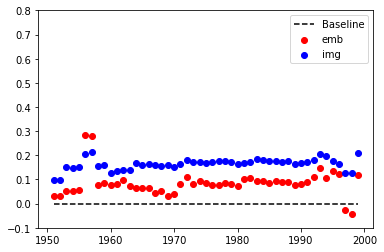

In [361]:
lists = sorted(it for it in emb_diff.items() if it[-1] != 0) # sorted by key, return a list of tuples
x_diff_x0, y_diff_x0 = zip(*lists)

lists = sorted(it for it in img_diff.items() if it[-1] != 0) # sorted by key, return a list of tuples

x_diff_x1, y_diff_x1 = zip(*lists)

y_baseline = [0.0 for _ in x_diff_x0]

plt.scatter(x_diff_x0, y_diff_x0, color='red', label='emb')
plt.scatter(x_diff_x1, y_diff_x1, color='blue', label='img')

plt.plot(x_diff_x0, y_baseline, color='black', label='Baseline', linestyle='dashed')

#plt.yscale('symlog', basey=10, basex=10, linthreshy=0.2)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%0.3f')) #Here!
plt.ylim(ymax=0.8, ymin=-0.1)

plt.legend()
plt.show()

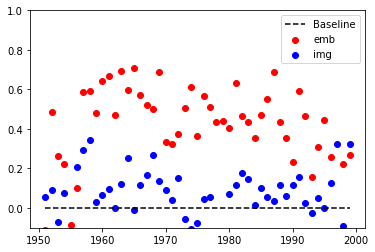

In [362]:
lists = sorted(it for it in emb_cpc.items() if it[-1] != 0) # sorted by key, return a list of tuples
x_diff_x0, y_diff_x0 = zip(*lists)

lists = sorted(it for it in img_cpc.items() if it[-1] != 0) # sorted by key, return a list of tuples

x_diff_x1, y_diff_x1 = zip(*lists)

y_baseline = [0.0 for _ in x_diff_x0]

plt.scatter(x_diff_x0, y_diff_x0, color='red', label='emb')
plt.scatter(x_diff_x1, y_diff_x1, color='blue', label='img')

plt.plot(x_diff_x0, y_baseline, color='black', label='Baseline', linestyle='dashed')

#plt.yscale('symlog', basey=10, basex=10, linthreshy=0.2)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%0.3f')) #Here!
plt.ylim(ymax=1, ymin=-0.1)

plt.legend()
plt.show()

In [21]:
np.array(y_diff_x0).mean(), np.array(y_diff_x1).mean()

(0.06117853853437635, 0.09653912092510022)

In [26]:
np.array(y_cpc_x0).mean(), np.array(y_cpc_x1).mean()

(-0.5128994600640403, -0.5182439935834784)

In [31]:
scores[1010]['cpc_emb_v14_run_x11_a_x0'], scores[1010]['cpc_emb_run_x11_a_x0']

(VolumeCutout(0.40501598, dtype=float32),
 VolumeCutout(0.82940435, dtype=float32))

In [40]:
for i in range(1300, 1350):
    #print (i)
    if i in emb_diff and emb_diff[i] < 0:
        print (i, emb_diff[i])

1310 -0.014723360538482666
1319 -0.010295689105987549
1320 -0.006379902362823486
1327 -0.024768054485321045
1328 -0.05214351415634155
1329 -0.026741862297058105
1330 -0.01818406581878662
1334 -0.010693609714508057
1339 -0.002771914005279541


/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'basex'. In the future this will raise TypeError
  if sys.path[0] == '':
/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'basex'. In the future this will raise TypeError
  del sys.path[0]


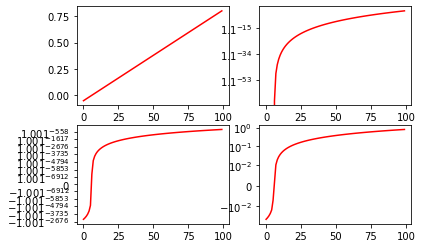

In [173]:
import matplotlib.pyplot as plt
from matplotlib import ticker

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False) 

fig, axs = plt.subplots(2, 2)



axs[0, 1].set_yscale('log', basey=1.1)
axs[1, 0].set_yscale('symlog', basex=1.001, basey=1.001, linthreshy=0.001)
axs[1, 1].set_yscale('symlog', basey=10, basex=10, linthreshy=0.01)

axs[0, 0].plot(np.linspace(-0.05, 0.8, 100), color='red', label='Normalized')
axs[0, 1].plot(np.linspace(-0.05, 0.8, 100), color='red', label='Normalized')
axs[1, 0].plot(np.linspace(-0.05, 0.8, 100), color='red', label='Normalized')
axs[1, 1].plot(np.linspace(-0.05, 0.8, 100), color='red', label='Normalized')

plt.show()

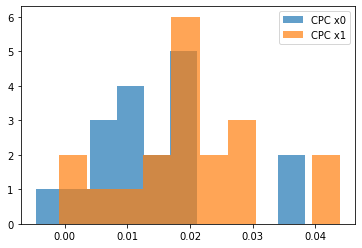

In [48]:
import random
import numpy
from matplotlib import pyplot


bins = numpy.linspace(-0.05, 0.5, 40)
bins = 10
#pyplot.hist(y_diff_x0, bins=bins, alpha=0.7, label='DIFF x0')
#pyplot.hist(y_diff_x1, bins=bins, alpha=0.7, label='DIFF x1')
pyplot.hist(y_cpc_x0, bins=bins, alpha=0.7, label='CPC x0')
pyplot.hist(y_cpc_x1, bins=bins, alpha=0.7, label='CPC x1')

#pyplot.hist(y_emb, bins, alpha=0.7, label='Embedding')
pyplot.legend(loc='upper right')
pyplot.show()

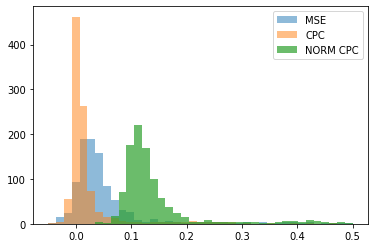

In [35]:
import random
import numpy
from matplotlib import pyplot


bins = numpy.linspace(-0.05, 0.5, 40)
#bins = 30
pyplot.hist(y_emb, bins=bins, alpha=0.5, label='MSE')
pyplot.hist(y_emb_cpc, bins=bins, alpha=0.5, label='CPC')
#pyplot.hist(y_norm_cpc, bins=bins, alpha=0.7, label='NORM CPC')
#pyplot.hist(y_emb, bins, alpha=0.7, label='Embedding')
pyplot.legend(loc='upper right')
pyplot.show()

In [31]:
np.array(y_emb).mean()

0.06880007225502904

In [34]:
np.percentile(np.array(y_emb), 50)

0.03214883804321289

In [29]:
sum([y > 0.05 for y in y_emb])

VolumeCutout(301)